# Import libraries

In [1]:
import random
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns

from pymongo import MongoClient
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.style.use('bmh') #setting up 'bmh' as "Bayesian Methods for Hackers" style sheet

# Define MongoDB connection

In [2]:
client = MongoClient("mongodb://localhost:27017")
collection = client.cmp1044.yelp_reviews

# Overview Visualization

## Count distinct users/products/reviews

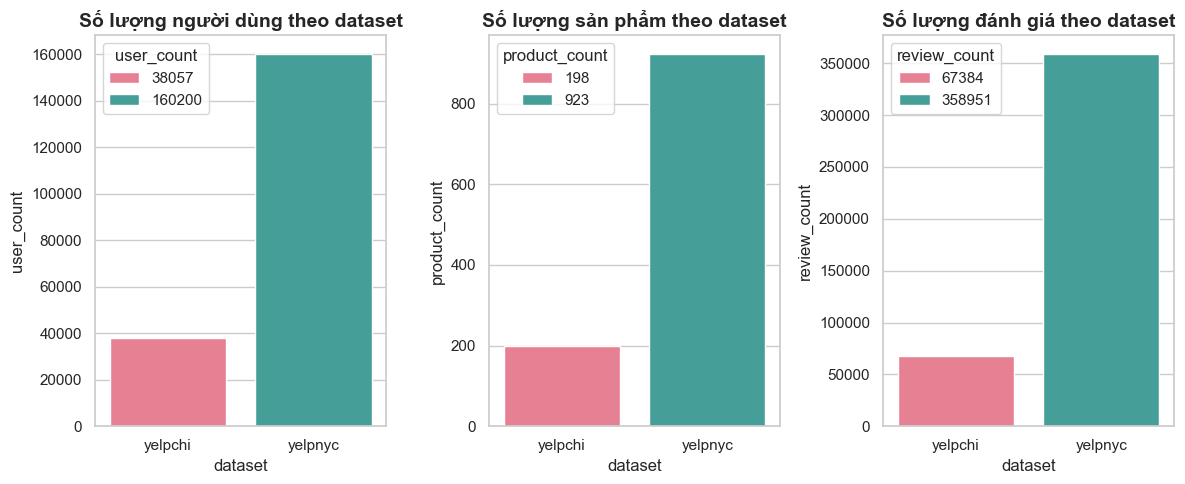

In [3]:
pipeline_users = [
    {"$group": {"_id": "$dataset", "count": {"$addToSet": "$user"}}},
    {"$project": {"dataset": "$_id", "user_count": {"$size": "$count"}}},
    {"$sort": {"dataset": 1}}
]

pipeline_products = [
    {"$group": {"_id": "$dataset", "count": {"$addToSet": "$product"}}},
    {"$project": {"dataset": "$_id", "product_count": {"$size": "$count"}}},
    {"$sort": {"dataset": 1}}
]

pipeline_reviews = [
    {"$group": {"_id": "$dataset", "count": {"$sum": 1}}},
    {"$project": {"dataset": "$_id", "review_count": "$count"}},
    {"$sort": {"dataset": 1}}
]

users_count = pd.DataFrame(collection.aggregate(pipeline_users))
products_count = pd.DataFrame(collection.aggregate(pipeline_products))
reviews_count = pd.DataFrame(collection.aggregate(pipeline_reviews))

custom_palette = sns.color_palette("husl", users_count.dataset.nunique())

# Visualize the results using Seaborn/Matplotlib
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot Users Count
sns.barplot(x="dataset", y="user_count", hue="user_count", data=users_count, ax=axes[0], palette=custom_palette)
axes[0].set_title('Số lượng người dùng theo dataset', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# Plot Products Count
sns.barplot(x="dataset", y="product_count", hue="product_count", data=products_count, ax=axes[1], palette=custom_palette)
axes[1].set_title('Số lượng sản phẩm theo dataset', fontdict={'fontsize': 14, 'fontweight': 'bold'})

# Plot Reviews Count
sns.barplot(x="dataset", y="review_count", hue="review_count", data=reviews_count, ax=axes[2], palette=custom_palette)
axes[2].set_title('Số lượng đánh giá theo dataset', fontdict={'fontsize': 14, 'fontweight': 'bold'})

plt.tight_layout()
plt.show()

### Count distinct users/products/reviews by different label/rating/content_emotion

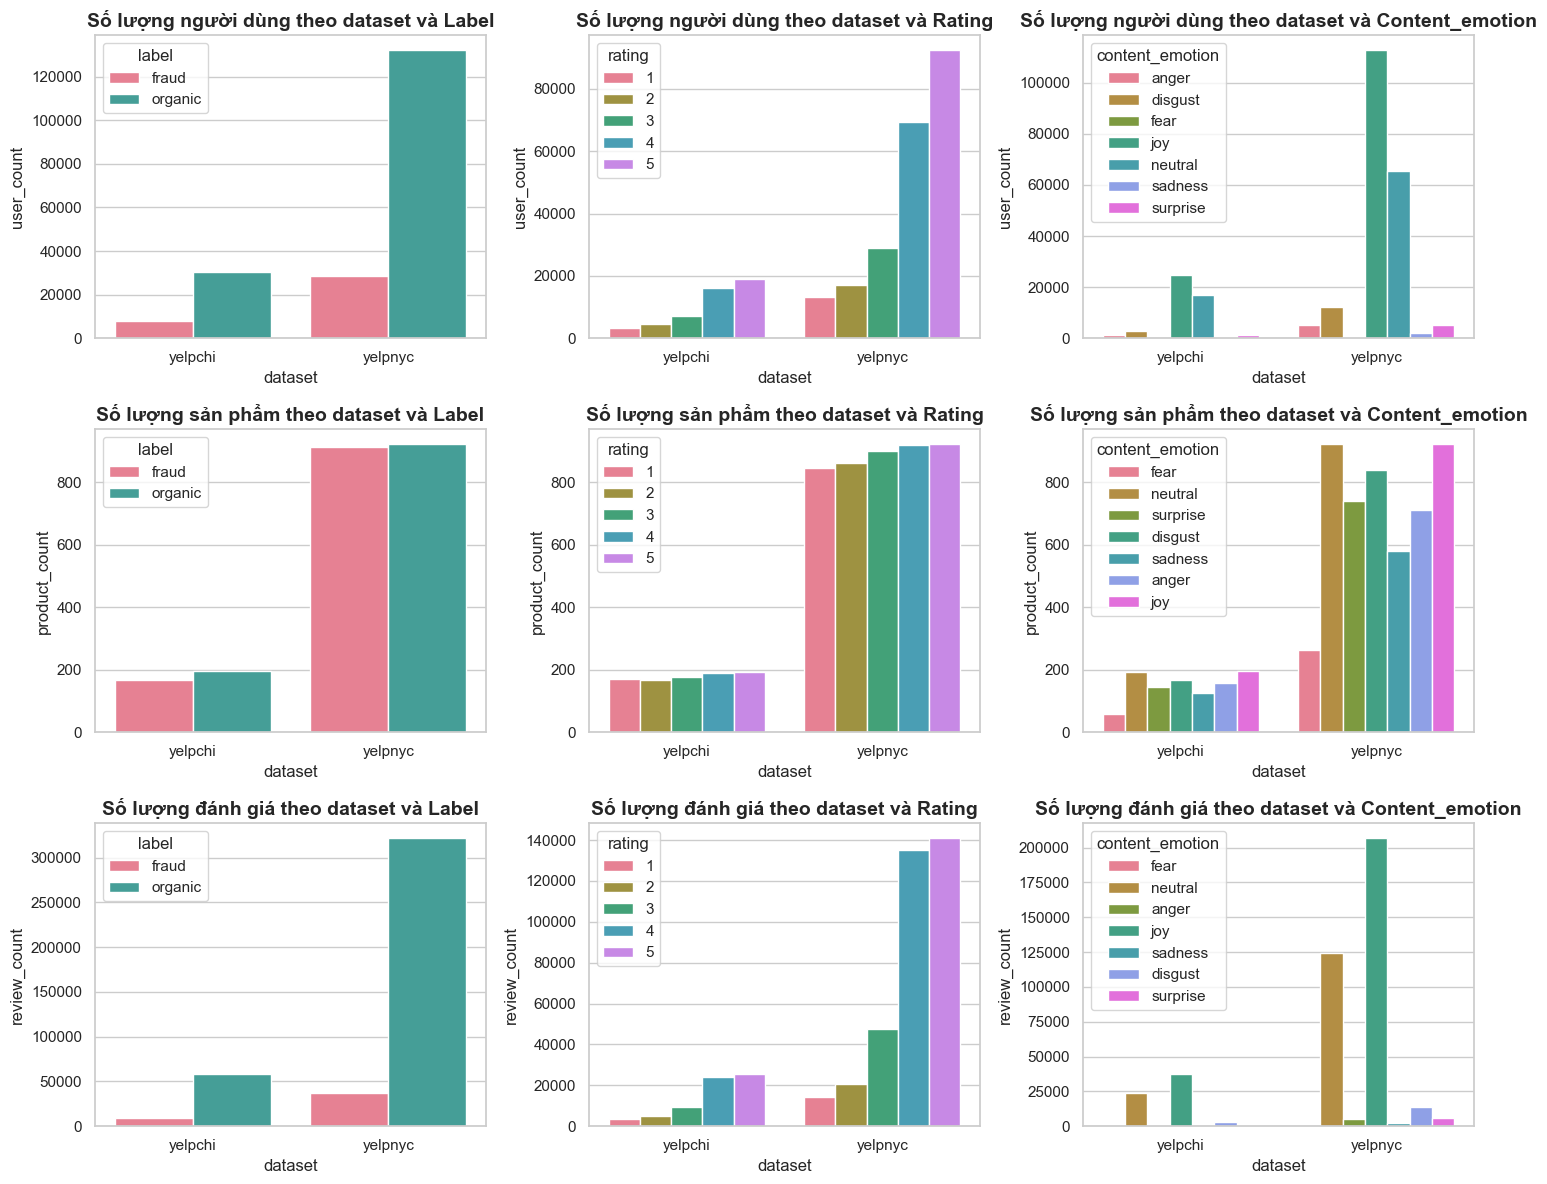

In [4]:
# Visualize the results using Seaborn/Matplotlib
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, field in enumerate(["label", "rating", "content_emotion"]):
    # Count distinct users, products, and reviews by different datasets
    pipeline_users = [
        {"$group": {"_id": {"dataset": "$dataset", field: f"${field}"}, "count": {"$addToSet": "$user"}}},
        {"$project": {"dataset": "$_id.dataset", field: f"$_id.{field}", "user_count": {"$size": "$count"}}},
        {"$sort": {"dataset": 1, field: 1}}
    ]
    
    pipeline_products = [
        {"$group": {"_id": {"dataset": "$dataset", field: f"${field}"}, "count": {"$addToSet": "$product"}}},
        {"$project": {"dataset": "$_id.dataset", field: f"$_id.{field}", "product_count": {"$size": "$count"}}},
        {"$sort": {"dataset": 1}}
    ]
    
    pipeline_reviews = [
        {"$group": {"_id": {"dataset": "$dataset", field: f"${field}"}, "count": {"$sum": 1}}},
        {"$project": {"dataset": "$_id.dataset", field: f"$_id.{field}", "review_count": "$count"}},
        {"$sort": {"dataset": 1}}
    ]
    
    users_count = pd.DataFrame(collection.aggregate(pipeline_users))
    products_count = pd.DataFrame(collection.aggregate(pipeline_products))
    reviews_count = pd.DataFrame(collection.aggregate(pipeline_reviews))
    
    custom_palette = sns.color_palette("husl", reviews_count[field].nunique())
    
    # Plot Users Count
    sns.barplot(x="dataset", y="user_count", hue=field, data=users_count, ax=axes[0, i], palette=custom_palette)
    axes[0, i].set_title(f'Số lượng người dùng theo dataset và {field.capitalize()}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    
    # Plot Products Count
    sns.barplot(x="dataset", y="product_count", hue=field, data=products_count, ax=axes[1, i], palette=custom_palette)
    axes[1, i].set_title(f'Số lượng sản phẩm theo dataset và {field.capitalize()}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    
    # Plot Reviews Count
    sns.barplot(x="dataset", y="review_count", hue=field, data=reviews_count, ax=axes[2, i], palette=custom_palette)
    axes[2, i].set_title(f'Số lượng đánh giá theo dataset và {field.capitalize()}', fontdict={'fontsize': 14, 'fontweight': 'bold'})
    
plt.tight_layout()
plt.show()

# Review Distributions

In [5]:
data = pd.DataFrame(collection.aggregate([
    {"$project": {
        "dataset": 1, 
        "label": 1, 
        "rating": 1, 
        "content_emotion": 1, 
        "content_polarity": 1, 
        "content_subjectivity": 1, 
        "content_wordcount": {"$size": "$content_words"}}
    },
    {"$sort": {"dataset": 1}}
]))

data.head()

,_id,dataset,rating,label,content_polarity,content_subjectivity,content_emotion,content_wordcount
0,659f7eb07722ec561c229b73,yelpchi,3,organic,-0.047,0.625,neutral,53
1,659f7eb07722ec561c229b74,yelpchi,3,organic,-0.435,0.505,disgust,49
2,659f7eb07722ec561c229b75,yelpchi,1,organic,-0.265,0.557,disgust,82
3,659f7eb07722ec561c229b76,yelpchi,5,organic,0.025,0.570,neutral,412
4,659f7eb07722ec561c229b77,yelpchi,2,organic,0.211,0.497,surprise,15


## Distribution of Reviews by rating/content_emotion (discrete)

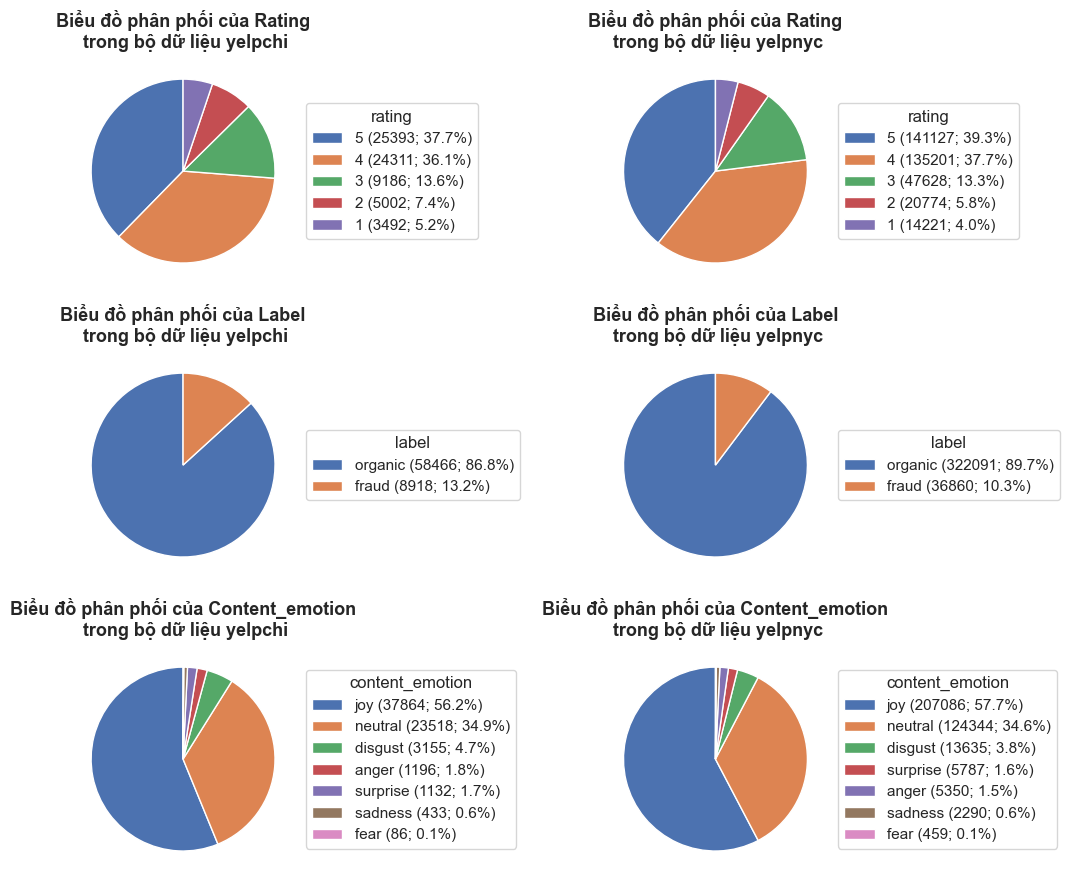

In [6]:
fields_to_visualize = ["rating", "label", "content_emotion"]
datasets = data.dataset.unique()

sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(len(fields_to_visualize), len(datasets), figsize=(12, 9))

# Iterate through datasets and fields and create pie charts
for i, field in enumerate(fields_to_visualize):
    for j, dataset in enumerate(datasets):
        # Get data for the field and dataset from the collection
        curr_data = pd.DataFrame(collection.find({"dataset": dataset}, {field: 1}))

        # Count the occurrences of each unique value
        value_counts = curr_data[field].value_counts()

        # Plot pie chart
        wedges, texts, autotexts = axes[i, j].pie(
            value_counts, 
            autopct='', 
            startangle=90,
        )

        # Add legend
        legend_labels = [
            f'{label} ({count}; {percentage:.1f}%)' 
            for label, count, percentage in zip(value_counts.index, value_counts, (value_counts / value_counts.sum()) * 100)
        ]
        axes[i, j].legend(wedges, legend_labels, title=field, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

        # Set title
        axes[i, j].set_title(f'Biểu đồ phân phối của {field.capitalize()}\n trong bộ dữ liệu {dataset}', fontdict={'fontsize': 13, 'fontweight': 'bold'})

# Adjust layout
plt.tight_layout()
plt.show()

## Distribution of Reviews by content_polarity/content_subjectivity/word_count (continuous)

### Boxplot

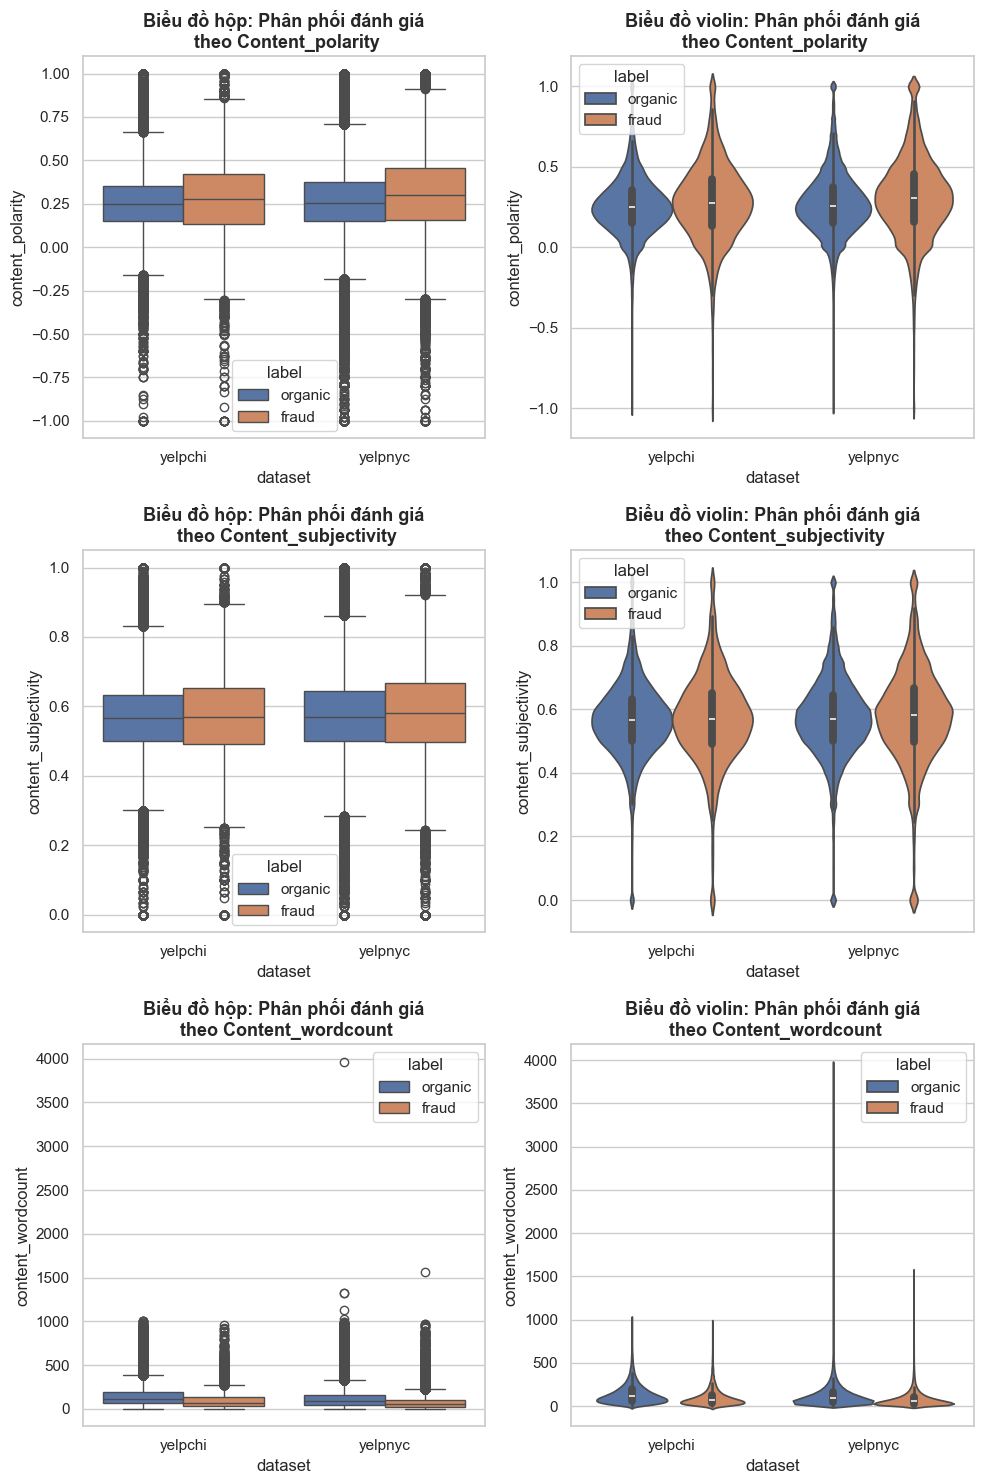

In [7]:
fields_to_visualize = ["content_polarity", "content_subjectivity", "content_wordcount"]

sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(len(fields_to_visualize), 2, figsize=(10, 15))

# Iterate through continuous fields and create boxplots
for i, field in enumerate(fields_to_visualize):
    sns.boxplot(x="dataset", y=field, hue="label", hue_order=["organic", "fraud"],  data=data, ax=axes[i, 0])
    axes[i, 0].set_title(f'Biểu đồ hộp: Phân phối đánh giá\n theo {field.capitalize()}', fontdict={'fontsize': 13, 'fontweight': 'bold'})
    sns.violinplot(x="dataset", y=field, hue="label", hue_order=["organic", "fraud"],  data=data, ax=axes[i, 1])
    axes[i, 1].set_title(f'Biểu đồ violin: Phân phối đánh giá\n theo {field.capitalize()}', fontdict={'fontsize': 13, 'fontweight': 'bold'})

# Adjust layout
plt.tight_layout()
plt.show()

### Histograms

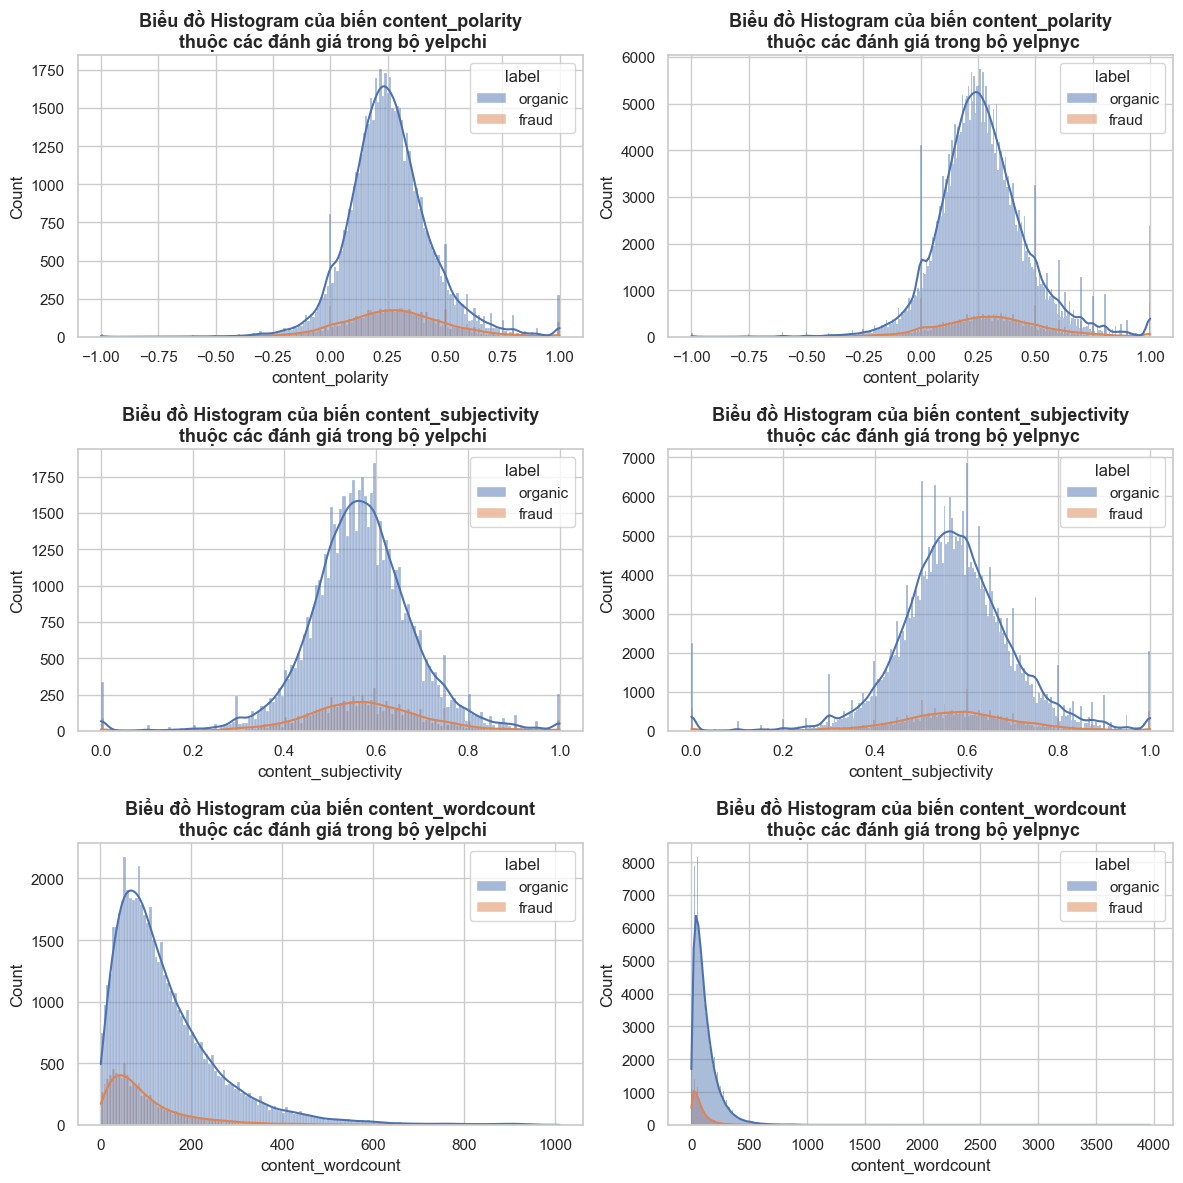

In [8]:
fields_to_visualize = ["content_polarity", "content_subjectivity", "content_wordcount"]

fig, axes = plt.subplots(len(fields_to_visualize), data.dataset.nunique(), figsize=(12, 12))

# Iterate through continuous fields and create boxplots
for i, field in enumerate(fields_to_visualize):
    for j, dataset in enumerate(data.dataset.unique()):
        sns.histplot(x=field, hue="label", hue_order=["organic", "fraud"], kde=True, data=data[data.dataset==dataset], ax=axes[i, j])
        axes[i, j].set_title(f'Biểu đồ Histogram của biến {field}\n thuộc các đánh giá trong bộ {dataset}', fontdict={'fontsize': 13, 'fontweight': 'bold'})

# Adjust layout
plt.tight_layout()
plt.show()

### Pointplot by rating

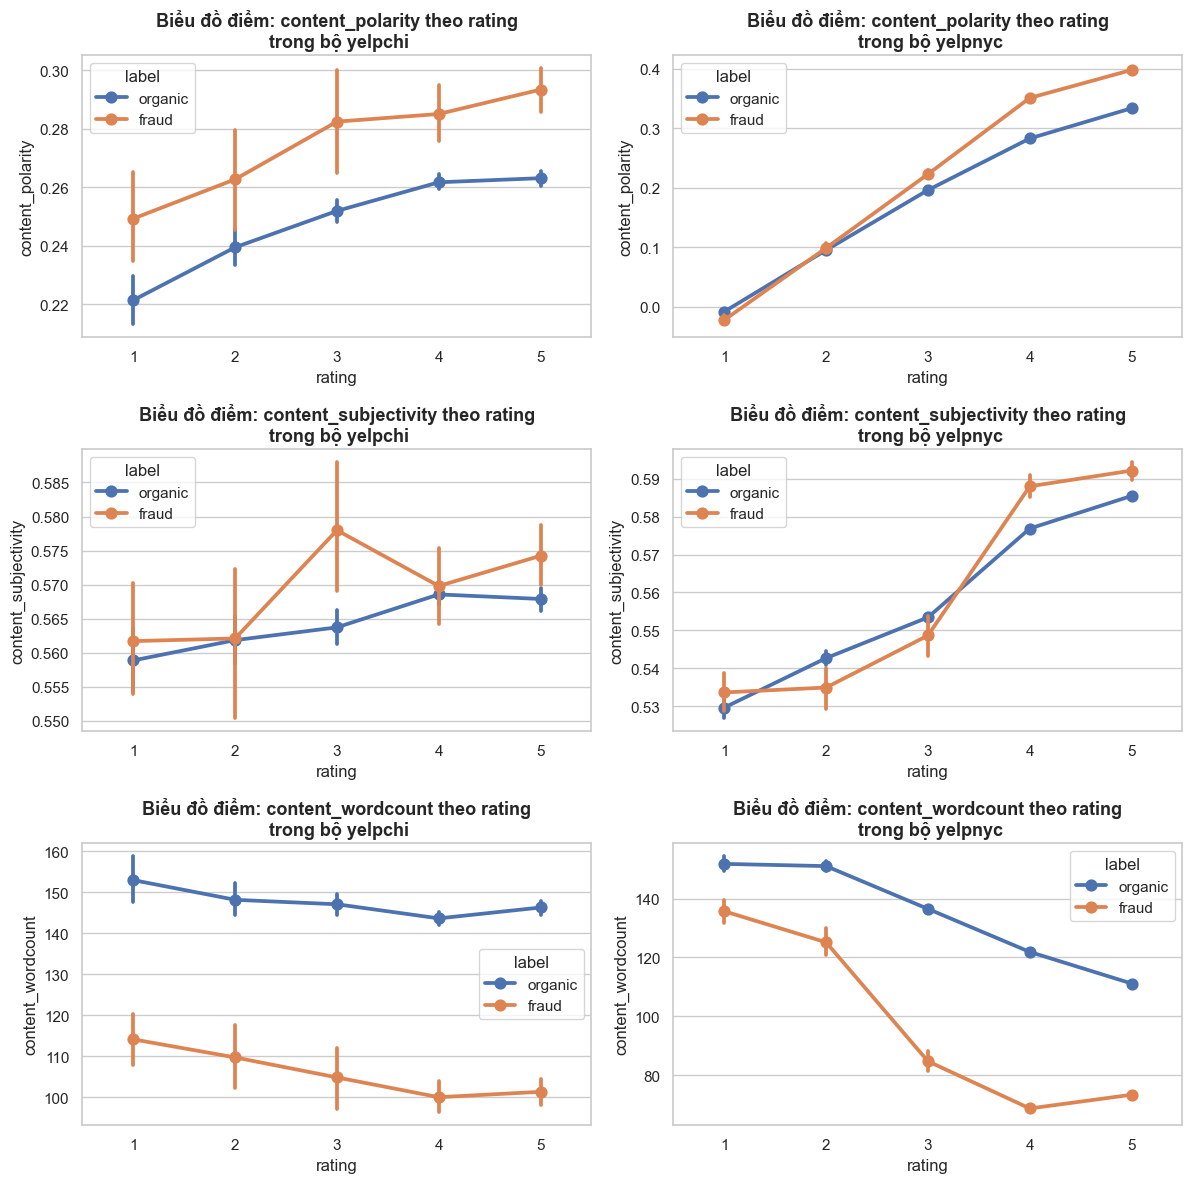

In [9]:
fields_to_visualize = ["content_polarity", "content_subjectivity", "content_wordcount"]

fig, axes = plt.subplots(len(fields_to_visualize), data.dataset.nunique(), figsize=(12, 12))

# Iterate through continuous fields and create boxplots
for i, field in enumerate(fields_to_visualize):
    for j, dataset in enumerate(data.dataset.unique()):
        sns.pointplot(
            x="rating", 
            y=field, 
            hue="label", 
            hue_order=["organic", "fraud"], 
            data=data[data.dataset==dataset], 
            ax=axes[i, j],
        )
        axes[i, j].set_title(f'Biểu đồ điểm: {field} theo rating\n trong bộ {dataset}', fontdict={'fontsize': 13, 'fontweight': 'bold'})

# Adjust layout
plt.tight_layout()
plt.show()

### Pointplot by emotion

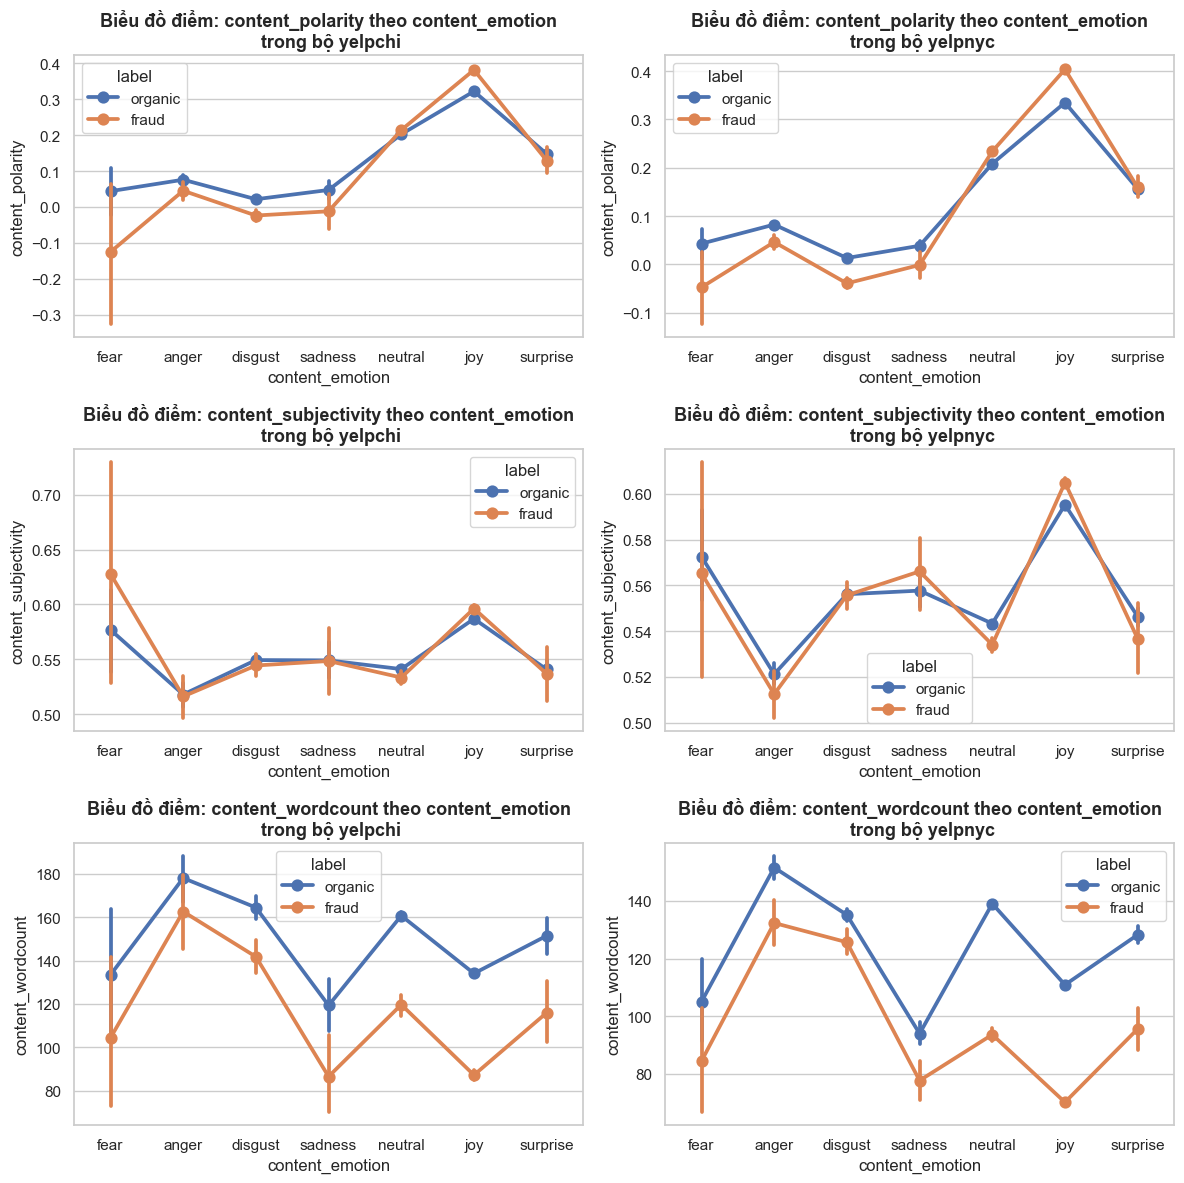

In [10]:
fields_to_visualize = ["content_polarity", "content_subjectivity", "content_wordcount"]

fig, axes = plt.subplots(len(fields_to_visualize), data.dataset.nunique(), figsize=(12, 12))

# Iterate through continuous fields and create boxplots
for i, field in enumerate(fields_to_visualize):
    for j, dataset in enumerate(data.dataset.unique()):
        sns.pointplot(
            x="content_emotion", 
            y=field, 
            hue="label", 
            hue_order=["organic", "fraud"], 
            order=['fear', 'anger', 'disgust', 'sadness', 'neutral', 'joy', 'surprise'],
            data=data[data.dataset==dataset],
            ax=axes[i, j],
        )
        axes[i, j].set_title(f'Biểu đồ điểm: {field} theo content_emotion\n trong bộ {dataset}', fontdict={'fontsize': 13, 'fontweight': 'bold'})
        
# Adjust layout
plt.tight_layout()
plt.show()

# Feature correlations

In [11]:
data = pd.DataFrame(collection.aggregate([
    {"$project": {
        "_id": 0,
        "dataset": 1, 
        "label": 1, 
        "rating": 1, 
        "content_polarity": 1, 
        "content_subjectivity": 1, 
        "content_emotion": 1, 
        "content_wordcount": {"$size": "$content_words"}}
    },
]))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426335 entries, 0 to 426334
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   dataset               426335 non-null  object 
 1   rating                426335 non-null  int64  
 2   label                 426335 non-null  object 
 3   content_polarity      426335 non-null  float64
 4   content_subjectivity  426335 non-null  float64
 5   content_emotion       426335 non-null  object 
 6   content_wordcount     426335 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 22.8+ MB


### Convert Categorical variables into Numerical ones

In [12]:
label_enc = LabelEncoder()
data['label'] = label_enc.fit_transform(data['label'])
data['content_emotion'] = label_enc.fit_transform(data['content_emotion'])
data.head()

,dataset,rating,label,content_polarity,content_subjectivity,content_emotion,content_wordcount
0,yelpchi,3,1,-0.047,0.625,4,53
1,yelpchi,3,1,-0.435,0.505,1,49
2,yelpchi,1,1,-0.265,0.557,1,82
3,yelpchi,5,1,0.025,0.570,4,412
4,yelpchi,2,1,0.211,0.497,6,15


In [13]:
for dataset in data.dataset.unique():
    print(f"Tương quan giữa giá trị label (label = 1 là đánh giá gian lận) và các biến trong bộ {dataset}")
    print(data[data.dataset==dataset].drop(columns=["dataset"]).corr()['label'])
    print()

Tương quan giữa giá trị label (label = 1 là đánh giá gian lận) và các biến trong bộ yelpchi
rating                  0.045675
label                   1.000000
content_polarity       -0.042629
content_subjectivity   -0.011095
content_emotion         0.081845
content_wordcount       0.118081
Name: label, dtype: float64

Tương quan giữa giá trị label (label = 1 là đánh giá gian lận) và các biến trong bộ yelpnyc
rating                  0.022588
label                   1.000000
content_polarity       -0.057247
content_subjectivity   -0.010018
content_emotion         0.054990
content_wordcount       0.111979
Name: label, dtype: float64



### Draw correlation heatmap

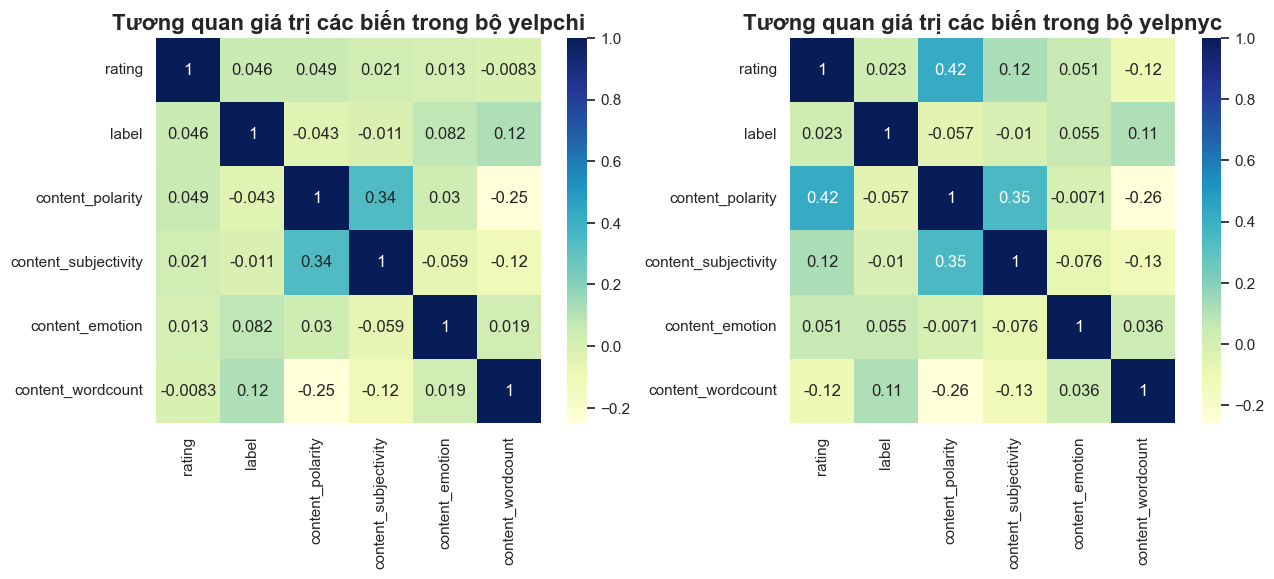

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, dataset in enumerate(data.dataset.unique()):
    sns.heatmap(
        data[data.dataset==dataset].drop(columns=["dataset"]).corr(), 
        square=True,annot=True,cmap='YlGnBu',linecolor="white", ax=axes[i],
    )
    axes[i].set_title(f'Tương quan giá trị các biến trong bộ {dataset}', fontdict={'fontsize': 16, 'fontweight': 'bold'})

# Word Cloud

In [15]:
data = pd.DataFrame(collection.aggregate([
    {"$project": {
        "_id": 0,
        "dataset": 1,
        "label": 1, 
        "content_text": 1}
    },
]))

data.head()

,dataset,label,content_text
0,yelpchi,organic,The only place inside the Loop that you can st...
1,yelpchi,organic,"This place is disgusting, absolutely horrible,..."
2,yelpchi,organic,Disgusting!!! There is literally duct tape hol...
3,yelpchi,organic,Let me begin by saying that there are two kind...
4,yelpchi,organic,"Good location, really run down. I am surprised..."


In [16]:
# Function to generate word cloud
def generate_wordcloud(ax, text, title):
    wordcloud = WordCloud(width=400, height=400, max_words=144, max_font_size=96, min_font_size=16, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontdict={'fontsize': 18, 'fontweight': 'bold'})

### Word Cloud on YelpChi

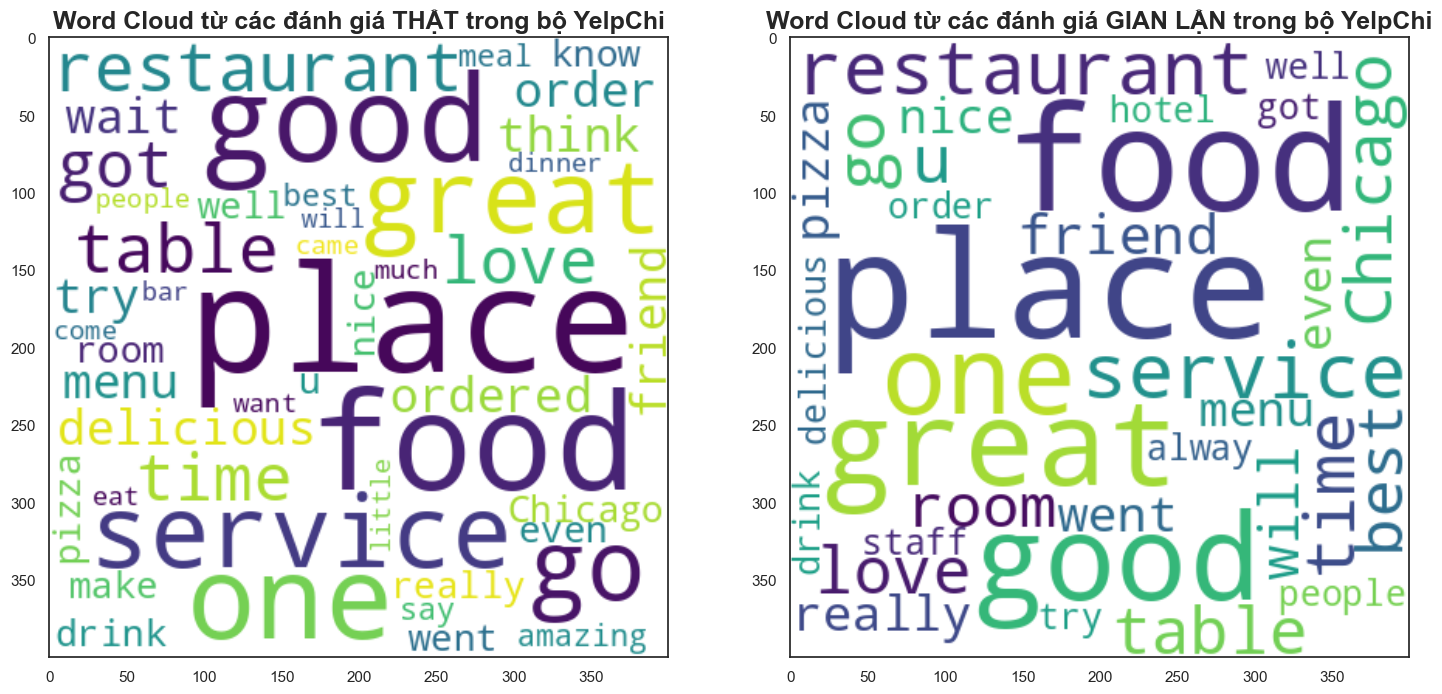

In [17]:
# Create a subplot grid based on the number of unique labels
sns.set(style="white")

df = data[data.dataset=="yelpchi"]
unique_labels = df['label'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 7))

# Generate word clouds for each label
for i, label in enumerate(unique_labels):
    df_label = df[df['label'] == label]
    generate_wordcloud(axes[i], ' '.join(df_label['content_text']), 
                       f'Word Cloud từ các đánh giá {"GIAN LẬN" if label == "fraud" else "THẬT"} trong bộ YelpChi')

plt.tight_layout()
plt.show()

### World Cloud on YelpNYC

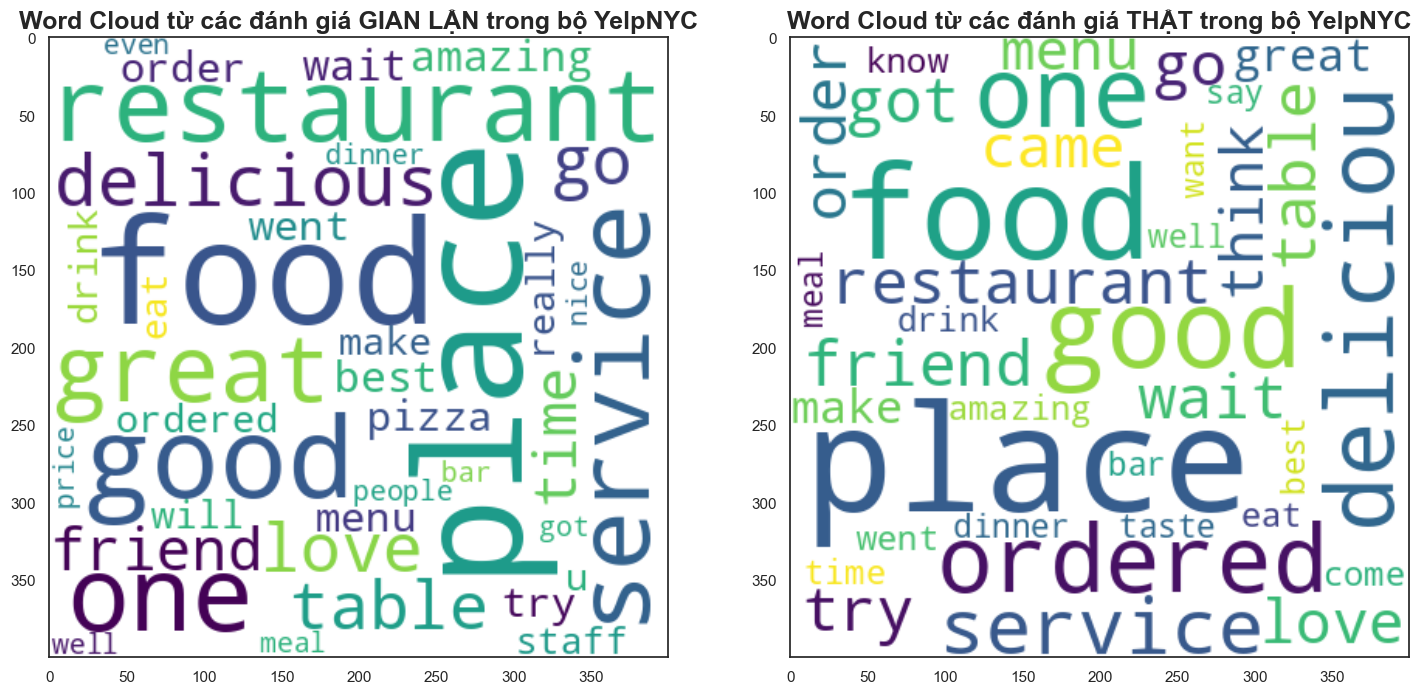

In [18]:
# Create a subplot grid based on the number of unique labels
sns.set(style="white")

df = data[data.dataset=="yelpnyc"]
unique_labels = df['label'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 7))

# Generate word clouds for each label
for i, label in enumerate(unique_labels):
    df_label = df[df['label'] == label]
    generate_wordcloud(axes[i], ' '.join(df_label['content_text']), 
                       f'Word Cloud từ các đánh giá {"GIAN LẬN" if label == "fraud" else "THẬT"} trong bộ YelpNYC')

plt.tight_layout()
plt.show()